## REGENERATION
## TEAM 3

# Preprocessing/Feature Engineering

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import collections
from scipy import stats
from difflib import SequenceMatcher

In [2]:
df = pd.read_excel("mpg.data.xlsx")

In [3]:
# used to select correct columns
df.drop(df.iloc[:, 9:13], inplace = True, axis = 1)
df

,mpg,cylinders,displayments,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
401,27.0,4,140.0,86.0,2790,15.6,82,1,ford mustang gl
402,44.0,4,97.0,52.0,2130,24.6,82,2,vw pickup
403,32.0,4,135.0,84.0,2295,11.6,82,1,dodge rampage
404,28.0,4,120.0,79.0,2625,18.6,82,1,ford ranger


In [4]:
#Κύλινδροι 3->4 και 5-->6
df['cylinders'].replace({3: 4, 5: 6}, inplace=True)

In [5]:
#Μετατροπή origin σε string αφού είναι nominal και όχι ordinal
df['origin'] = df['origin'].astype('str')

## Missing Values 

In [6]:
# Χρησιμοποιούμε τον SVR regressor ώστε να συμπληρώσουμε τα missing values του horsepower

from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

df1 = df.dropna()

sourceData = df1[['mpg','acceleration','cylinders', 'displayments', 'weight']]
targetData = df1[['horsepower']]

xTrain, xTest, yTrain, yTest = train_test_split(sourceData, targetData)
horsePowerClassifier = SVR(kernel='linear')
horsePowerClassifier = horsePowerClassifier.fit(xTrain, yTrain.values.flatten())
score = horsePowerClassifier.score(xTest, yTest.values.flatten())
print(f'score: {score}')

score: 0.853518642650258


In [7]:
# Εύρεση των missing horsepower values
for rowId in df.index[df['horsepower'].isna()]:
    row = df.iloc[rowId]
    values = row[['mpg', 'acceleration','cylinders', 'displayments', 'weight']]
    prediction = horsePowerClassifier.predict([values])[0]
    df.at[rowId, 'horsepower'] = prediction

df.isna().sum()

mpg             8
cylinders       0
displayments    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

In [8]:
#Εφόσον πλέον έχουμε null μόνο στο mpg για τη δημιουργία ενός regression του mpg, οι στήλες με missing values στο mpg
#δεν βοηθούν
df = df.dropna()
df

,mpg,cylinders,displayments,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
401,27.0,4,140.0,86.0,2790,15.6,82,1,ford mustang gl
402,44.0,4,97.0,52.0,2130,24.6,82,2,vw pickup
403,32.0,4,135.0,84.0,2295,11.6,82,1,dodge rampage
404,28.0,4,120.0,79.0,2625,18.6,82,1,ford ranger


## Clustering

 Επαναλαμβάνω τις διαδικασίες που έγιναν και στο EDA

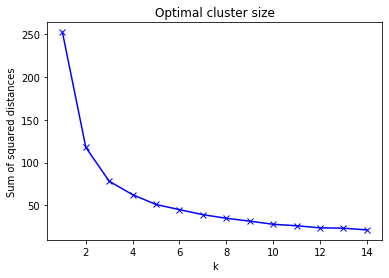

In [9]:
# Θα κάνουμε έναν έλεγχο για να δούμε αν υπάρχουν clusters στα data
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

# ορίζω το seed μου
np.random.seed(0)

# Διώχνουμε το car name
dfC = df[['cylinders','displayments','horsepower','weight','acceleration','model year','origin']]
#κάνουμε drop τα NA. Αν αποφασίσουμε να διατηρήσουμε το clustering θα επιστρέψουμε σε αυτό το θέμα
dfC = dfC.dropna()
# origin σε αιρθμούς εδώ μεσα στο dfC 
#dfC['origin'] = dfC['origin'].astype('int')
# θα χρειαστούμε κανονικοποίηση
mms = MinMaxScaler()
mms.fit(dfC)
data_transformed = mms.transform(dfC)

# υπολογισμός στα sum of squared distances και εύρεση του optimal k
sum_of_squared_distances = []
clusterRange = range(1, 15)
for k in clusterRange:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    sum_of_squared_distances.append(km.inertia_)

# Visualization του τελευταιου
plt.plot(clusterRange, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Optimal cluster size')
plt.show()

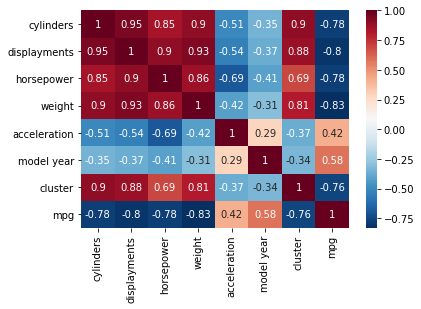

In [10]:
# Παρατηρήσεις
# με n_clusters=3 βρίσκει σχεδόν το origin!!!
# με n_clusters=2 έχει καλό correlation με τα υπόλοιπα και πολύ καλή με mpg!!!

km = KMeans(n_clusters=2)
km = km.fit(data_transformed)

dfC['cluster'] = km.fit_predict(data_transformed)
dfC['mpg'] = df['mpg']
plt.figure()
sns.heatmap(dfC.corr(), cmap='RdBu_r', annot=True)
plt.show()

2


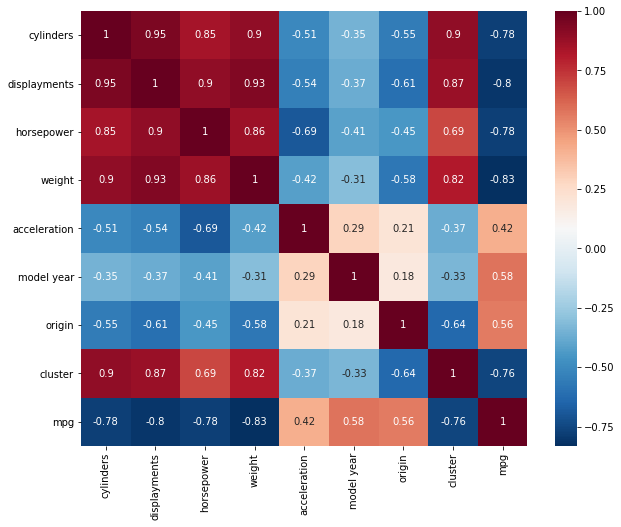

In [11]:
# MeanShift Cluster exploration
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html
# βρίσκει ότι όντως το optimal cluster size = 2
from sklearn.cluster import MeanShift

cluster = MeanShift()
cluster = cluster.fit(data_transformed)

n_clusters_ = len(cluster.cluster_centers_)
print(n_clusters_)

dfC['origin'] = dfC['origin'].astype('int')
dfC['cluster'] = cluster.fit_predict(data_transformed)
plt.figure(figsize=(10,8))
sns.heatmap(dfC.corr(), cmap='RdBu_r', annot=True)
plt.show()

In [12]:
dfC

,cylinders,displayments,horsepower,weight,acceleration,model year,origin,cluster,mpg
0,8,307.0,130.0,3504,12.0,70,1,1,18.0
1,8,350.0,165.0,3693,11.5,70,1,1,15.0
2,8,318.0,150.0,3436,11.0,70,1,1,18.0
3,8,304.0,150.0,3433,12.0,70,1,1,16.0
4,8,302.0,140.0,3449,10.5,70,1,1,17.0
...,...,...,...,...,...,...,...,...,...
401,4,140.0,86.0,2790,15.6,82,1,0,27.0
402,4,97.0,52.0,2130,24.6,82,2,0,44.0
403,4,135.0,84.0,2295,11.6,82,1,0,32.0
404,4,120.0,79.0,2625,18.6,82,1,0,28.0


## One-hot encoding

In [13]:
#Του origin / getdummies
dfC = pd.get_dummies(dfC, columns=['origin'])

In [14]:
dfC

,cylinders,displayments,horsepower,weight,acceleration,model year,cluster,mpg,origin_1,origin_2,origin_3
0,8,307.0,130.0,3504,12.0,70,1,18.0,1,0,0
1,8,350.0,165.0,3693,11.5,70,1,15.0,1,0,0
2,8,318.0,150.0,3436,11.0,70,1,18.0,1,0,0
3,8,304.0,150.0,3433,12.0,70,1,16.0,1,0,0
4,8,302.0,140.0,3449,10.5,70,1,17.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
401,4,140.0,86.0,2790,15.6,82,0,27.0,1,0,0
402,4,97.0,52.0,2130,24.6,82,0,44.0,0,1,0
403,4,135.0,84.0,2295,11.6,82,0,32.0,1,0,0
404,4,120.0,79.0,2625,18.6,82,0,28.0,1,0,0


In [15]:
# Το κρατάω και αυτό ώστε να το έχω στη διάθεση μου στους πειραματισμούς για εύρεση regression
dfC['origin'] = df['origin']
dfC

,cylinders,displayments,horsepower,weight,acceleration,model year,cluster,mpg,origin_1,origin_2,origin_3,origin
0,8,307.0,130.0,3504,12.0,70,1,18.0,1,0,0,1
1,8,350.0,165.0,3693,11.5,70,1,15.0,1,0,0,1
2,8,318.0,150.0,3436,11.0,70,1,18.0,1,0,0,1
3,8,304.0,150.0,3433,12.0,70,1,16.0,1,0,0,1
4,8,302.0,140.0,3449,10.5,70,1,17.0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
401,4,140.0,86.0,2790,15.6,82,0,27.0,1,0,0,1
402,4,97.0,52.0,2130,24.6,82,0,44.0,0,1,0,2
403,4,135.0,84.0,2295,11.6,82,0,32.0,1,0,0,1
404,4,120.0,79.0,2625,18.6,82,0,28.0,1,0,0,1


## Index re-ordering and CSV export

In [16]:
dfC = dfC.reset_index()

In [17]:
dfC

,index,cylinders,displayments,horsepower,weight,acceleration,model year,cluster,mpg,origin_1,origin_2,origin_3,origin
0,0,8,307.0,130.0,3504,12.0,70,1,18.0,1,0,0,1
1,1,8,350.0,165.0,3693,11.5,70,1,15.0,1,0,0,1
2,2,8,318.0,150.0,3436,11.0,70,1,18.0,1,0,0,1
3,3,8,304.0,150.0,3433,12.0,70,1,16.0,1,0,0,1
4,4,8,302.0,140.0,3449,10.5,70,1,17.0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,401,4,140.0,86.0,2790,15.6,82,0,27.0,1,0,0,1
394,402,4,97.0,52.0,2130,24.6,82,0,44.0,0,1,0,2
395,403,4,135.0,84.0,2295,11.6,82,0,32.0,1,0,0,1
396,404,4,120.0,79.0,2625,18.6,82,0,28.0,1,0,0,1


In [18]:
del dfC['index']

In [19]:
dfC

,cylinders,displayments,horsepower,weight,acceleration,model year,cluster,mpg,origin_1,origin_2,origin_3,origin
0,8,307.0,130.0,3504,12.0,70,1,18.0,1,0,0,1
1,8,350.0,165.0,3693,11.5,70,1,15.0,1,0,0,1
2,8,318.0,150.0,3436,11.0,70,1,18.0,1,0,0,1
3,8,304.0,150.0,3433,12.0,70,1,16.0,1,0,0,1
4,8,302.0,140.0,3449,10.5,70,1,17.0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
393,4,140.0,86.0,2790,15.6,82,0,27.0,1,0,0,1
394,4,97.0,52.0,2130,24.6,82,0,44.0,0,1,0,2
395,4,135.0,84.0,2295,11.6,82,0,32.0,1,0,0,1
396,4,120.0,79.0,2625,18.6,82,0,28.0,1,0,0,1


In [21]:
#Τελικό αρχείο. Βγάζει σε στήλη και το index
dfC.to_csv("extracted.data.csv")